In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (20, 10)
import warnings
warnings.filterwarnings('ignore')
from dowhy import gcm
from dowhy.utils import plot, bar_plot



/Users/jbanerje/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbanerje/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/var/folders/jn/zl4rcc1s56s5p6fm169l94mc0000gn/T/ipykernel_79092/2582267487.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at ht

### Notes
- We have metrics for all of these nodes
- Not sure about the impact for mixing CPU starvation in percentage with latency metrics in this model
- https://access.redhat.com/articles/6271341
- https://access.redhat.com/solutions/4770281
- https://access.redhat.com/solutions/4885641



In [2]:
causal_graph_actual = nx.DiGraph([('CPUStarvation', 'etcdResponseTime'),
                           ('etcdNetworkPeer', 'etcdResponseTime'),
                           ('etcdBackendCommitDur', 'etcdResponseTime'),
                           ('etcdWallSyncDur', 'etcdResponseTime'),
                           ('etcdResponseTime', 'APIServerCache'),
                           ('etcdResponseTime', 'APIServerResponseTime'),
                           ('APIServerCache', 'APIServerResponseTime')
                          ])

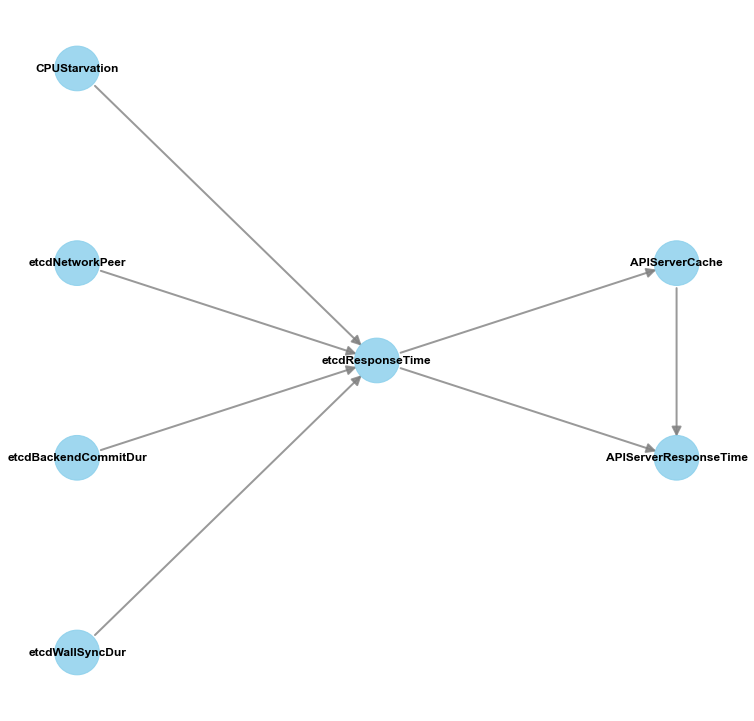

In [3]:
plot(causal_graph_actual, figure_size=[13, 13])

Do we have any metric about cache response time of API Server? I really hope so because that is a key component in this causal flow. But since I am not aware, I remove it from the `used` graph.

In [4]:
causal_graph_used = nx.DiGraph([('CPUStarvation', 'etcdResponseTime'),
                           ('etcdNetworkPeer', 'etcdResponseTime'),
                           ('etcdBackendCommitDur', 'etcdResponseTime'),
                           ('etcdWallSyncDur', 'etcdResponseTime'),
                           ('etcdResponseTime', 'APIServerResponseTime')
                          ])

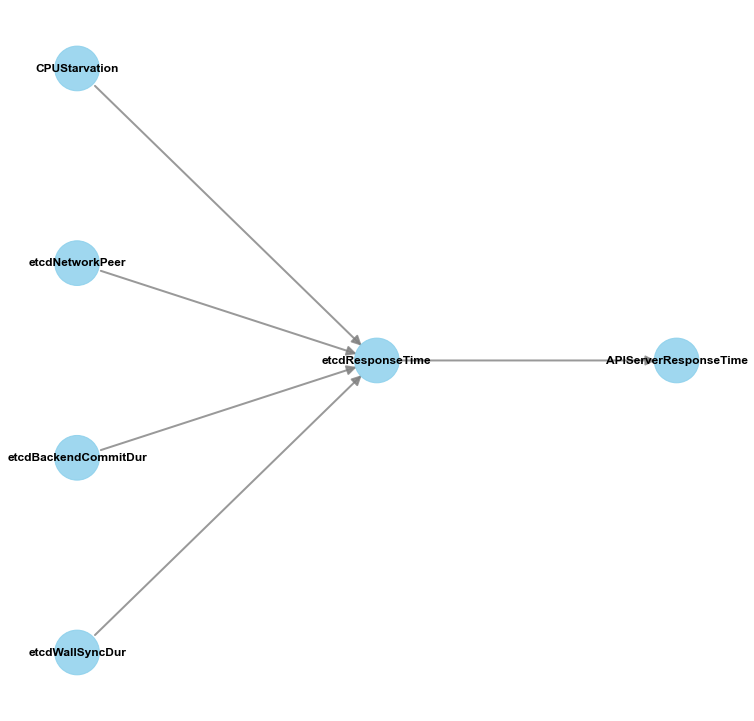

In [5]:
plot(causal_graph_used, figure_size=[13, 13])

In [6]:
def load_file(name) :
    
    fname = os.path.join(name)
    master_df = pd.read_csv(fname,index_col=0)
    return master_df



def prepare_file(raw_df):
    raw_df.rename(columns = {'etcdBackendCommitDuration':'etcdBackendCommitDur'}, inplace = True)
    raw_df.rename(columns = {'etcdWalSyncDuration':'etcdWallSyncDur'}, inplace = True)
    raw_df.rename(columns = {'etcdNetWorkPeerRoundTripDuration':'etcdNetworkPeer'}, inplace = True)
    raw_df.rename(columns = {'etcdDBLeaderElection':'CPUStarvation'}, inplace = True)
    raw_df.rename(columns = {'etcdCPUIOWaitDuration':'etcdResponseTime'}, inplace = True)
    raw_df.rename(columns = {'KubeAPICPUCoreUsage':'APIServerResponseTime'}, inplace = True)
    result_df=raw_df[['CPUStarvation','etcdBackendCommitDur','etcdWallSyncDur','etcdNetworkPeer','etcdResponseTime','APIServerResponseTime']]
    result_df=result_df.reset_index(drop=True)
    return result_df

# This renders histogram in 3 columns per row.
# Fixed format
def examine_skewness_using_histogram(df,colnames):
    #number of rows of display
    #given column =3
    #depends on lenght of colnames
    rowcount=math.ceil(len(colnames)/3)
    
    # Visualizing skewness using histograms and density plots
    fig, axes = plt.subplots(nrows=rowcount, ncols=3, figsize=(10, 7))
    
    i=1
    for x in colnames :
        rowposition = (math.ceil(i/3)) -1
        colposition = i - (rowposition)*3 -1
        sns.histplot(df[x], kde=False, ax=axes[rowposition,colposition])
        axes[rowposition,colposition].set_title(x)    
        i += 1   
    
    plt.tight_layout()
    plt.show()

In [7]:
raw_df=load_file("causal-1.csv")
raw_df

,etcdDBLeaderElection,etcdBackendCommitDuration,etcdWalSyncDuration,etcdNetWorkPeerRoundTripDuration,etcdCPUIOWaitDuration,KubeAPICPUCoreUsage,ACMCPUCoreUsage
timestamp,,,,,,,
1/30/24 21:47,6,0.000994,0.000992,0.012672,0.000595,2.000076,0.518400
1/30/24 21:48,6,0.003392,0.000994,0.012672,0.000595,1.430919,0.390506
1/30/24 21:49,6,0.000990,0.000992,0.012672,0.000595,1.351936,0.391677
1/30/24 21:50,6,0.000994,0.000994,0.012672,0.001190,0.861048,0.328888
1/30/24 21:51,6,0.000990,0.000996,0.012672,0.001190,1.208964,0.384734
...,...,...,...,...,...,...,...
2/2/24 22:52,0,0.000999,0.002204,0.012672,0.001190,1.106441,0.586645
2/2/24 22:53,0,0.003840,0.000999,0.012672,0.002976,1.433999,0.471708
2/2/24 22:54,0,0.000995,0.000992,0.012672,0.001190,1.146951,0.511221


In [8]:
stable_df=prepare_file(raw_df)
stable_df

,CPUStarvation,etcdBackendCommitDur,etcdWallSyncDur,etcdNetworkPeer,etcdResponseTime,APIServerResponseTime
0,6,0.000994,0.000992,0.012672,0.000595,2.000076
1,6,0.003392,0.000994,0.012672,0.000595,1.430919
2,6,0.000990,0.000992,0.012672,0.000595,1.351936
3,6,0.000994,0.000994,0.012672,0.001190,0.861048
4,6,0.000990,0.000996,0.012672,0.001190,1.208964
...,...,...,...,...,...,...
4380,0,0.000999,0.002204,0.012672,0.001190,1.106441
4381,0,0.003840,0.000999,0.012672,0.002976,1.433999
4382,0,0.000995,0.000992,0.012672,0.001190,1.146951
4383,0,0.000995,0.000992,0.012672,0.000595,1.263328


#### Let us draw the treatment and the outcome (or effect) and other metrics in good stable data

array([[<AxesSubplot:title={'center':'CPUStarvation'}>,
        <AxesSubplot:title={'center':'etcdBackendCommitDur'}>,
        <AxesSubplot:title={'center':'etcdWallSyncDur'}>],
       [<AxesSubplot:title={'center':'etcdNetworkPeer'}>,
        <AxesSubplot:title={'center':'etcdResponseTime'}>,
        <AxesSubplot:title={'center':'APIServerResponseTime'}>]],
      dtype=object)

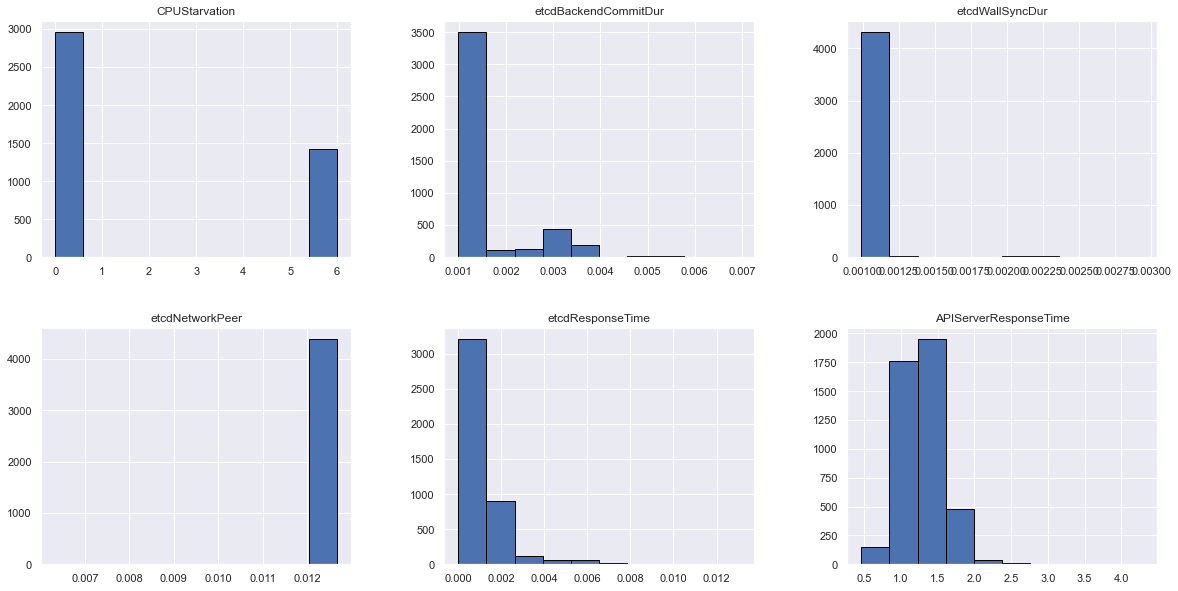

In [16]:
#need to debug what broke - examine_skewness_using_histogram(df,colnames) method
#define format for subplots (1 row and 3 columns)
fig, axis = plt.subplots(2, 3)

#create histogram for each column in DataFrame
#stable_df.hist(ax=axis)
stable_df.hist(ax=axis, edgecolor='black', grid=True)

Text(0.5, 1.0, 'etcResponsTime')

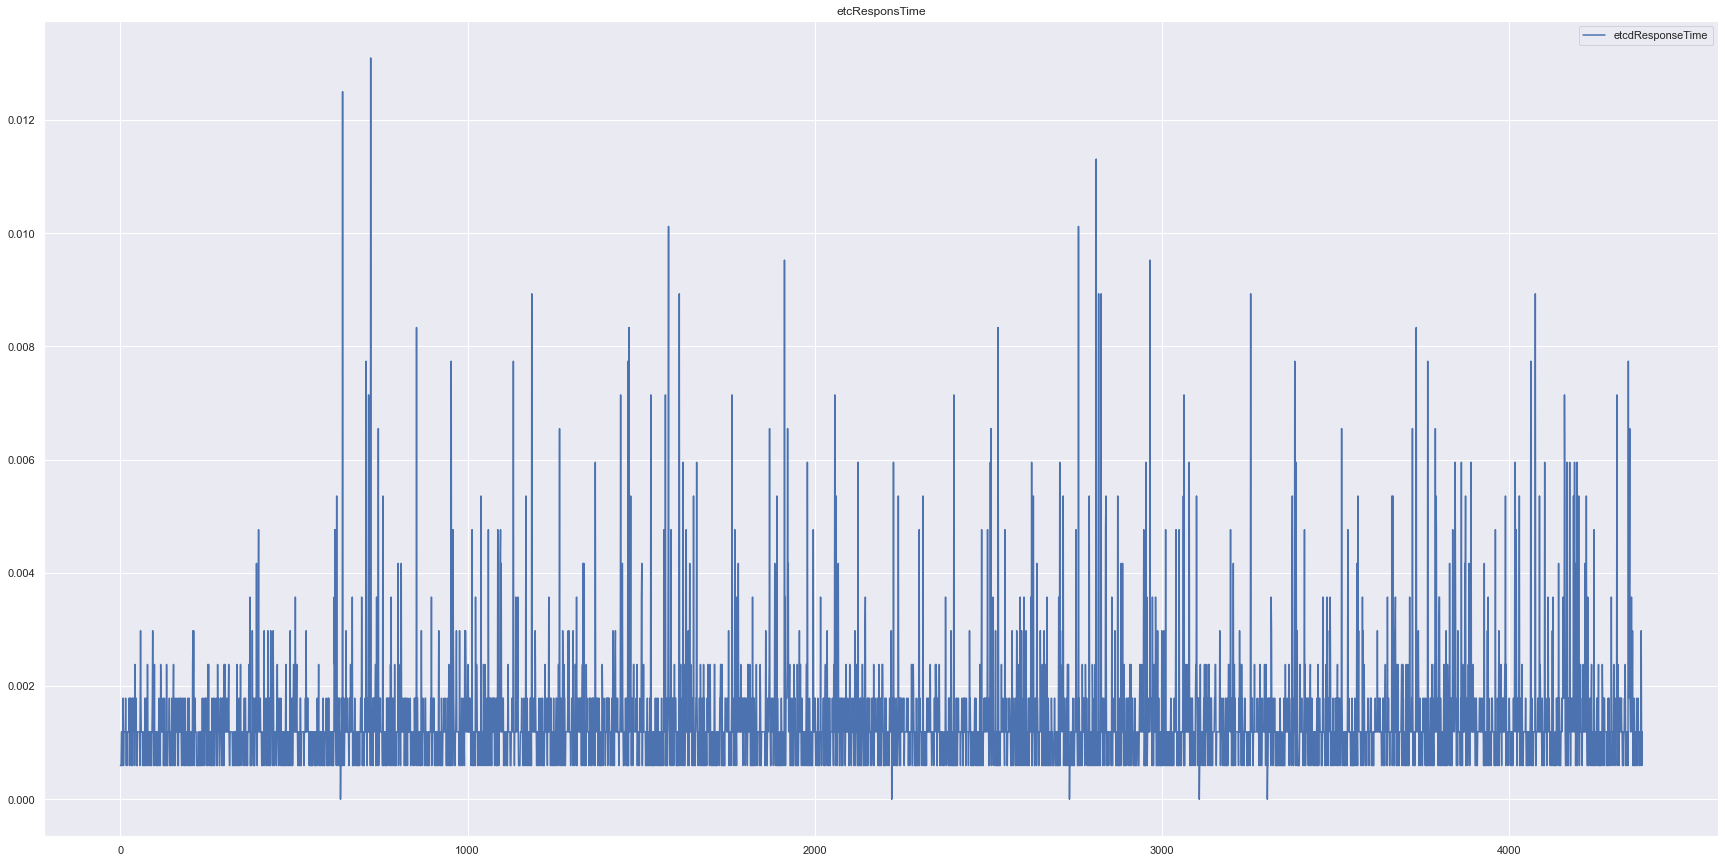

In [19]:
fig, ax = plt.subplots(figsize=(30,15)) 
stable_df.plot(y=["etcdResponseTime"], ax = ax)
plt.title("etcResponsTime")

Text(0.5, 1.0, 'APIServerResponseTime')

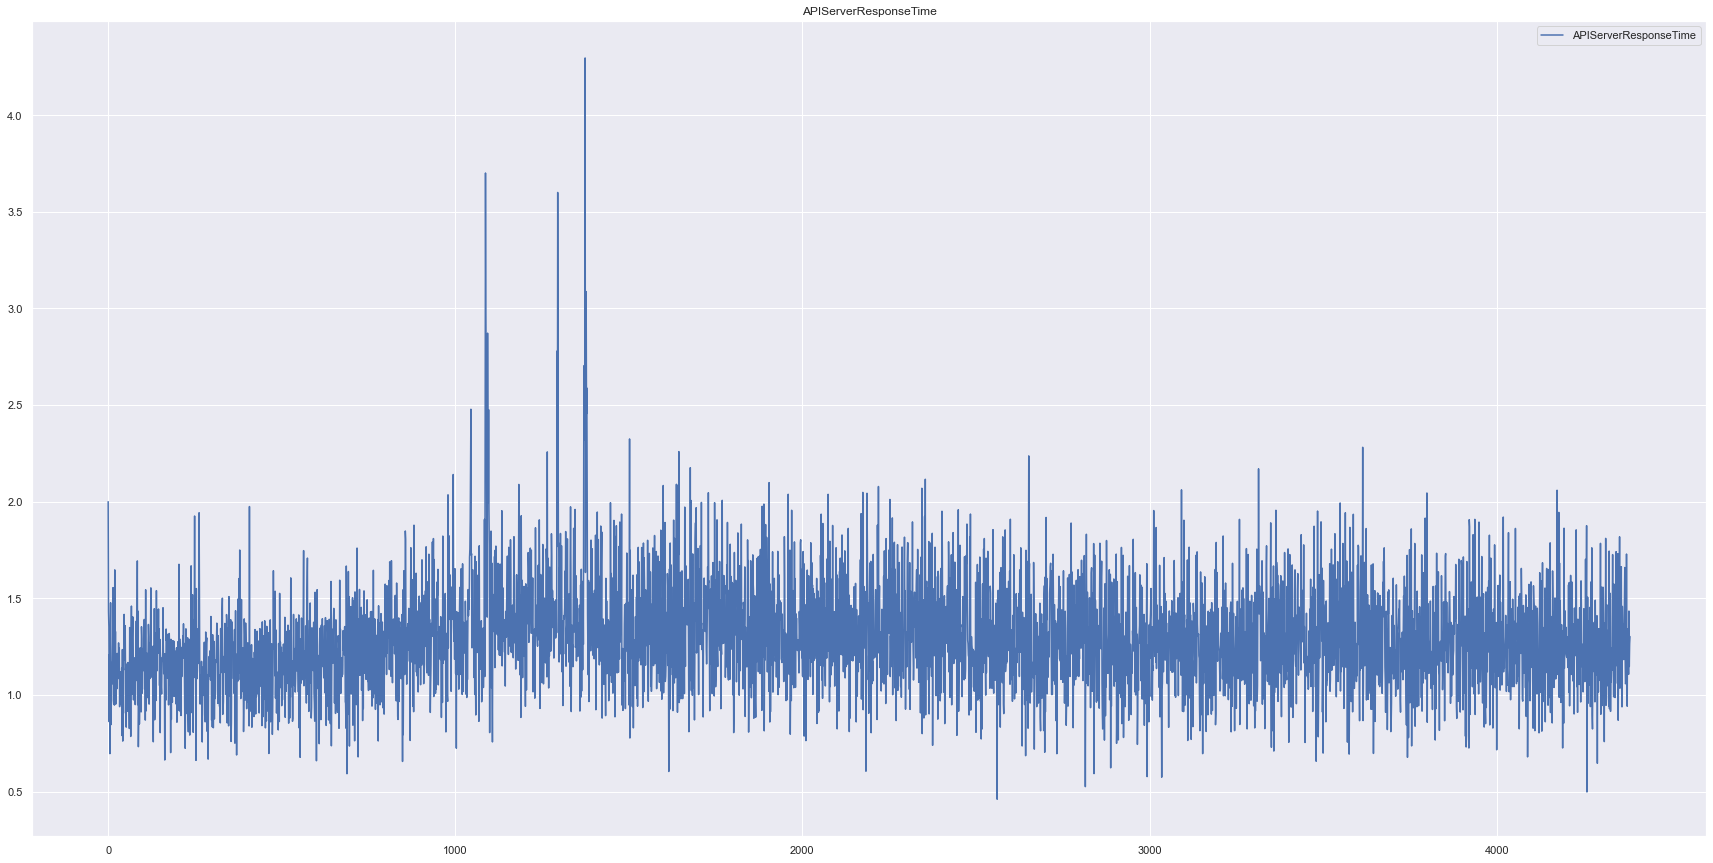

In [20]:
fig, ax = plt.subplots(figsize=(30,15)) 
stable_df.plot(y=["APIServerResponseTime"], ax = ax)
plt.title("APIServerResponseTime")

In [9]:
causal_model = gcm.StructuralCausalModel(causal_graph_used)

In [10]:
gcm.auto.assign_causal_mechanisms(causal_model, stable_df)

/Users/jbanerje/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbanerje/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbanerje/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/jbanerje/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently insta